In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import pickle
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## Dataset

In [ ]:
!kaggle datasets download -d nelgiriyewithana/emotions --unzip

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
License(s): other
 57% 9.00M/15.7M [00:00<00:00, 15.6MB/s]
100% 15.7M/15.7M [00:00<00:00, 28.1MB/s]


In [ ]:
data_path = '/content/text.csv'
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


Mengubah label dari indeks ke teks

In [ ]:
named_label = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
data['label'] = data['label'].map(named_label)

In [ ]:
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,fear
1,1,ive enjoyed being able to slouch about relax a...,sadness
2,2,i gave up my internship with the dmrg and am f...,fear
3,3,i dont know i feel so lost,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,fear


In [ ]:
sample = [data[data['label'] == named_label[i]].iloc[3].text for i in range(6)]
sample

['i can still lose the weight without feeling deprived',
 'i feel my portfolio demonstrates how eager i am to learn but some who know me better might call it annoyingly persistent',
 'i think a guy can make up for lacking funds in romantic ways to make his lady feel taken care of and loved',
 'i need to feel dangerous and pretty so here a striking dance pick deep in vogue minutes ago',
 'i dunno i just feel scared to walk in after awhile it got ok but when i walk into this room w poorly erected brick walls separating the room into xm partitions',
 'im feeling a bit amazed and grateful about having landed amid such a congregation']

In [ ]:
emotion_distribution = data['label'].value_counts()
print(emotion_distribution)

label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


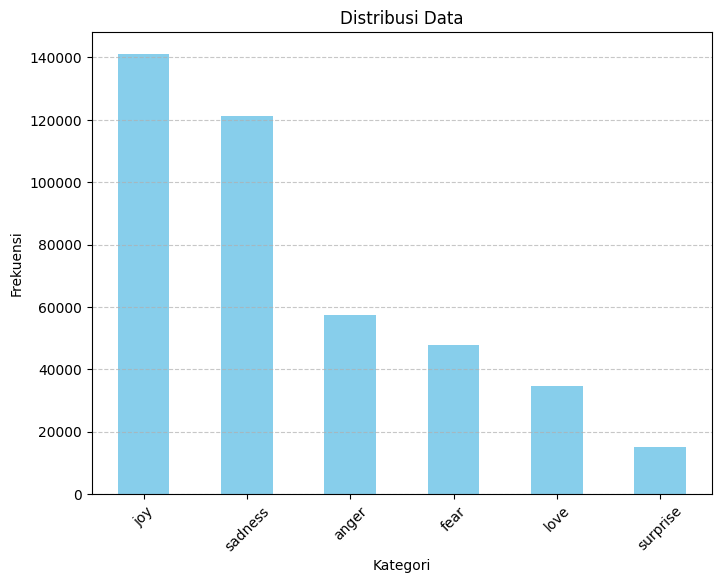

In [ ]:
plt.figure(figsize=(8, 6))
emotion_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribusi Data')
plt.xlabel('Kategori')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocessing

### Menghilangkan duplikasi

In [ ]:
duplicate_data = data[data.duplicated('text', keep=False)]['text']
f'Banyak teks yang muncul lebih dari sekali adalah {len(duplicate_data.unique())}'

'Banyak teks yang muncul lebih dari sekali adalah 22817'

In [ ]:
data.drop_duplicates('text', inplace=True)
print(f'Banyak teks setelah dihilangkan duplikasinya adalah: {len(data)}')

Banyak teks setelah dihilangkan duplikasinya adalah: 393822


### Cleansing dan Case Folding

In [ ]:
remove_unwanted_char = lambda s: re.sub(r'[^a-zA-Z0-9 ]+', '', s)
remove_whitelist = lambda s: ' '.join(s.split())
case_folding = lambda s: s.lower()

data['text'] = data['text'].apply(remove_unwanted_char).apply(remove_whitelist).apply(case_folding)

### Chatword expanding

In [ ]:
chat_words = {
 'afaik': 'as far as i know',
 'afk': 'away from keyboard',
 'asap': 'as soon as possible',
 'atk': 'at the keyboard',
 'atm': 'at the moment',
 'a3': 'anytime anywhere anyplace',
 'bak': 'back at keyboard',
 'bbl': 'be back later',
 'bbs': 'be back soon',
 'bfn': 'bye for now',
 'b4n': 'bye for now',
 'brb': 'be right back',
 'brt': 'be right there',
 'btw': 'by the way',
 'b4': 'before',
 'cu': 'see you',
 'cul8r': 'see you later',
 'cya': 'see you',
 'faq': 'frequently asked questions',
 'fc': 'fingers crossed',
 'fwiw': "for what its worth",
 'fyi': 'for your information',
 'gal': 'get a life',
 'gg': 'good game',
 'gn': 'good night',
 'gmta': 'great minds think alike',
 'gr8': 'great',
 'g9': 'genius',
 'ic': 'i see',
 'icq': 'i seek you',
 'ilu': 'i love you',
 'imho': 'in my honest opinion',
 'imo': 'in my opinion',
 'iow': 'in other words',
 'irl': 'in real life',
 'kiss': 'keep it simple stupid',
 'ldr': 'long distance relationship',
 'lmao': 'laugh my axx off',
 'lol': 'laughing out loud',
 'ltns': 'long time no see',
 'l8r': 'later',
 'mte': 'my thoughts exactly',
 'm8': 'mate',
 'nrn': 'no reply necessary',
 'oic': 'oh i see',
 'pita': 'pain in the axx',
 'prt': 'party',
 'prw': 'parents are watching',
 'qpsa?': 'que pasa',
 'rofl': 'rolling on the floor laughing',
 'roflol': 'rolling on the floor laughing out loud',
 'rotflmao': 'rolling on the floor laughing my axx off',
 'sk8': 'skate',
 'stats': 'your sex and age',
 'asl': 'age sex location',
 'thx': 'thank you',
 'ttfn': 'tata for now',
 'ttyl': 'talk to you later',
 'u': 'you',
 'u2': 'you too',
 'u4e': 'yours for ever',
 'wb': 'welcome back',
 'wtf': 'what the fxxx',
 'wtg': 'way to go',
 'wuf': 'where are you from',
 'w8': 'wait',
 '7k': 'sick laugher',
 'tfw': 'that feeling when',
 'mfw': 'my face when',
 'mrw': 'my reaction when',
 'ifyp': 'i feel your pain',
 'tntl': 'trying not to laugh',
 'jk': 'just kidding',
 'idc': "i dont care",
 'ily': 'i love you',
 'imu': 'i miss you',
 'adih': 'another day in hell',
 'zzz': 'sleeping bored tired',
 'wywh': 'wish you were here',
 'time': 'tears in my eyes',
 'bae': 'before anyone else',
 'fimh': 'forever in my heart',
 'bsaaw': 'big smile and a wink',
 'bwl': 'bursting with laughter',
 'bff': 'best friends forever',
 'csl': "cant stop laughing"
}

In [ ]:
def chatword_expanding(s):
  words = s.split()
  for i, word in enumerate(words):
    if word in chat_words:
      words[i] = chat_words[word]
  return ' '.join(words)

data['text'] = data['text'].apply(chatword_expanding)

### Stopword removal

In [ ]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(s):
  words = s.split()
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)

data['text'] = data['text'].apply(remove_stopwords)

### Stemming

In [ ]:
from nltk.stem import PorterStemmer

porter_stemmer = PorterStemmer()
stem_word = lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()])

data['text'] = data['text'].apply(stem_word)

## Dataset Split

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

In [ ]:
vocabs = set()
for x in X_train.apply(lambda s: set(s.split())):
  for w in x:
    if w not in vocabs:
      vocabs.add(w)
n_vocab = len(vocabs)

In [ ]:
f'Banyak vocabulary pada data train adalah {n_vocab}'

'Banyak vocabulary pada data train adalah 46082'

## Feature Extractor

In [ ]:
class FeatureExtractor:
  def __init__(self, max_feature=None):
    # CountVectorizer digunakan menghitung frekuensi dan menyimpannya dalam
    # tipe data sparse matrix sehingga hanya memerlukan lebih sedikit memory
    self.__tokenizer = CountVectorizer(max_features=max_feature)

  def __set_idf(self, freq):
    n = freq.shape[0] + 1
    df = np.bincount(freq.indices, minlength=freq.shape[1])
    dtype = freq.dtype if freq.dtype in (np.float64, np.float32) else np.float64
    df = df.astype(dtype, copy=False) + 1.0
    idf =  np.log(n / df) + 1.0
    self.__idf = idf

  def __normalize(self, X):
    n = X.shape[0]
    ptr = X.indptr
    dt = X.data
    for i in range(n):
      s = 0
      for j in range(ptr[i], ptr[i+1]):
        s += (dt[j] * dt[j])
      if s == 0:
        continue
      s = np.sqrt(s)
      for j in range(ptr[i], ptr[i+1]):
        X.data[j] /= s
    return X

  def fit(self, X):
    freq = self.__tokenizer.fit_transform(X)
    self.__set_idf(freq)

  def transform(self, X, only_tf=False):
    freq = self.__tokenizer.transform(X)
    dtype = freq.dtype if freq.dtype in (np.float64, np.float32) else np.float64
    tfidf = freq.astype(dtype, copy=True)
    if not only_tf:
      tfidf.data *= self.__idf[tfidf.indices]
    tfidf = self.__normalize(tfidf)
    return tfidf

## Experiment

Mengekstrak fitur data dimana banyak kata (vocabulary) dibatasi dengan threshold tertentu

In [ ]:
threshold = np.linspace(0, 1.0, num=51, endpoint=True)[1:]
extractor_data = []
for t in threshold:
  max_feat = int(t*n_vocab)
  data = {'max_feat': max_feat}
  extractor = FeatureExtractor(max_feature=max_feat)

  start = time.time()
  extractor.fit(X_train)
  fit_time = time.time() - start

  start = time.time()
  X_train_tfidf = extractor.transform(X_train)
  train_tfidf_time = time.time() - start
  start = time.time()
  X_test_tfidf = extractor.transform(X_test)
  test_tfidf_time = time.time() - start

  start = time.time()
  X_train_tf = extractor.transform(X_train, only_tf=True)
  train_tf_time = time.time() - start
  start = time.time()
  X_test_tf = extractor.transform(X_test, only_tf=True)
  test_tf_time = time.time() - start

  data['fit_time'] = fit_time
  data['train_tfidf_time'] = train_tfidf_time
  data['test_tfidf_time'] = test_tfidf_time
  data['train_tf_time'] = train_tf_time
  data['test_tf_time'] = test_tf_time
  data['train_tfidf'] = X_train_tfidf
  data['test_tfidf'] = X_test_tfidf
  data['train_tf'] = X_train_tf
  data['test_tf'] = X_test_tf

  extractor_data.append(data)

In [ ]:
labels = list(named_label.values())

Model Logistic Regression dengan bobot kelas *same*

In [ ]:
conf_data = []
for i,ed in enumerate(extractor_data[-1:]):
  X_train_tfidf = ed['train_tfidf']
  X_test_tfidf = ed['test_tfidf']
  X_train_tf = ed['train_tf']
  X_test_tf = ed['test_tf']

  conf_d = {}

  model = LogisticRegression(solver='saga', max_iter=1000)
  start = time.time()
  model.fit(X_train_tfidf, y_train)
  lr_tfidf_fit_time = time.time() - start
  y_train_pred = model.predict(X_train_tfidf)
  y_test_pred = model.predict(X_test_tfidf)
  conf_train = confusion_matrix(y_train, y_train_pred, labels=labels)
  conf_test = confusion_matrix(y_test, y_test_pred, labels=labels)
  conf_d['lr_tfidf_fit_time'] = lr_tfidf_fit_time
  conf_d['conf_tfidf_train'] = conf_train
  conf_d['conf_tfidf_test'] = conf_test

  model = LogisticRegression(solver='saga', max_iter=1000)
  start = time.time()
  model.fit(X_train_tf, y_train)
  lr_tf_fit_time = time.time() - start
  y_train_pred = model.predict(X_train_tf)
  y_test_pred = model.predict(X_test_tf)
  conf_train = confusion_matrix(y_train, y_train_pred, labels=labels)
  conf_test = confusion_matrix(y_test, y_test_pred, labels=labels)
  conf_d['lr_tf_fit_time'] = lr_tf_fit_time
  conf_d['conf_tf_train'] = conf_train
  conf_d['conf_tf_test'] = conf_test

  conf_data.append(conf_d)
  print(lr_tfidf_fit_time)
  print(lr_tf_fit_time)

Model Logistic Regression dengan bobot kelas *balanced*

In [ ]:
conf_data = []
for i,ed in enumerate(extractor_data[-1:]):
  X_train_tfidf = ed['train_tfidf']
  X_test_tfidf = ed['test_tfidf']
  X_train_tf = ed['train_tf']
  X_test_tf = ed['test_tf']

  conf_d = {}

  model = LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000)
  start = time.time()
  model.fit(X_train_tfidf, y_train)
  lr_tfidf_fit_time = time.time() - start
  y_train_pred = model.predict(X_train_tfidf)
  y_test_pred = model.predict(X_test_tfidf)
  conf_train = confusion_matrix(y_train, y_train_pred, labels=labels)
  conf_test = confusion_matrix(y_test, y_test_pred, labels=labels)
  conf_d['lr_tfidf_fit_time'] = lr_tfidf_fit_time
  conf_d['conf_tfidf_train'] = conf_train
  conf_d['conf_tfidf_test'] = conf_test

  model = LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000)
  start = time.time()
  model.fit(X_train_tf, y_train)
  lr_tf_fit_time = time.time() - start
  y_train_pred = model.predict(X_train_tf)
  y_test_pred = model.predict(X_test_tf)
  conf_train = confusion_matrix(y_train, y_train_pred, labels=labels)
  conf_test = confusion_matrix(y_test, y_test_pred, labels=labels)
  conf_d['lr_tf_fit_time'] = lr_tf_fit_time
  conf_d['conf_tf_train'] = conf_train
  conf_d['conf_tf_test'] = conf_test

  conf_data.append(conf_d)
  print(lr_tfidf_fit_time)
  print(lr_tf_fit_time)

## Analysis

In [ ]:
with open('/content/main_data.pk', 'rb') as f:
  pk_main = pickle.load(f)

In [ ]:
pk_main[0].keys()

dict_keys(['fit_time', 'train_tfidf_time', 'test_tfidf_time', 'train_tf_time', 'test_tf_time'])

In [ ]:
threshold = np.linspace(0, 1.0, num=51, endpoint=True)[1:]
freq = threshold * n_vocab

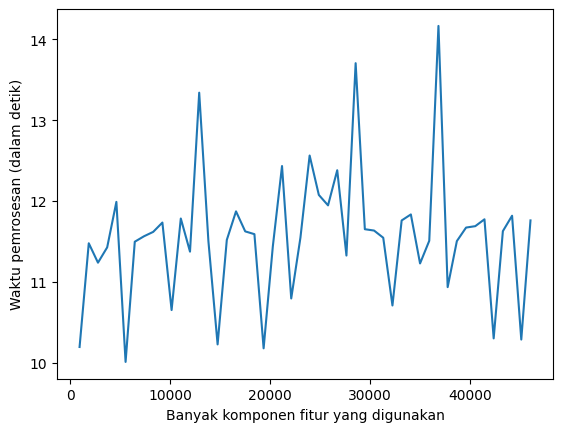

In [ ]:
fit_time = [(pk['fit_time']+pk['train_tfidf_time']) for pk in pk_main]
plt.plot(freq, fit_time)
plt.xlabel('Banyak komponen fitur yang digunakan')
plt.ylabel('Waktu pemrosesan (dalam detik)')
plt.show()

In [ ]:
tf_feat_t = np.array([pk['train_tf_time'] for pk in pk_main])
tfidf_feat_t = np.array([pk['train_tfidf_time'] for pk in pk_main])
print(f'TF: {np.mean(tf_feat_t)}')
print(f'TFIDF: {np.mean(tfidf_feat_t)}')
r = (np.mean(tfidf_feat_t) - np.mean(tf_feat_t)) / np.mean(tf_feat_t) * 100
print(f'ratio: {r}')

TF: 7.324586200714111
TFIDF: 7.409243779182434
ratio: 1.1558001523699633


In [ ]:
with open('/content/lr_conf_data.pk', 'rb') as f:
  pk_lr = pickle.load(f)

with open('/content/lrb_conf_data.pk', 'rb') as f:
  pk_lrb = pickle.load(f)

In [ ]:
pk_lr[0].keys()

dict_keys(['lr_tfidf_fit_time', 'conf_tfidf_train', 'conf_tfidf_test', 'lr_tf_fit_time', 'conf_tf_train', 'conf_tf_test'])

In [ ]:
lr_time = [pk['lr_tf_fit_time'] for pk in pk_lr]
lrb_time = [pk['lr_tf_fit_time']*10 for pk in pk_lrb]

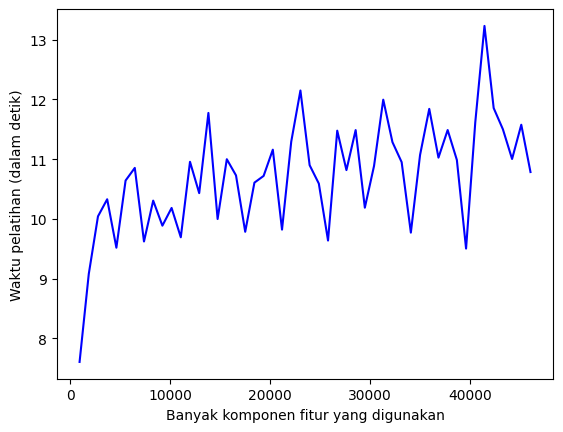

In [ ]:
plt.plot(freq, lr_time, color='blue')
plt.xlabel('Banyak komponen fitur yang digunakan')
plt.ylabel('Waktu pelatihan (dalam detik)')
plt.show()

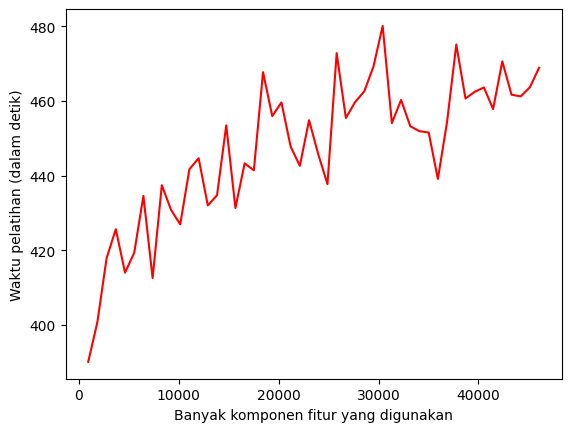

In [ ]:
plt.plot(freq, lrb_time, color='red')
plt.xlabel('Banyak komponen fitur yang digunakan')
plt.ylabel('Waktu pelatihan (dalam detik)')
plt.show()

In [ ]:
def macro_avg(data):
  return np.mean(data)

def my_metr(conf_mt):
  acc = np.trace(conf_mt) / np.sum(conf_mt)
  pr = np.diagonal(conf_mt) / np.sum(conf_mt, axis=0)
  rc = np.diagonal(conf_mt) / np.sum(conf_mt, axis=1)
  f1 = 2*pr*rc/(pr+rc)
  return acc, macro_avg(pr), macro_avg(rc), macro_avg(f1)

In [ ]:
idxs = [0, 14, 29, 49]
res = []
for i in idxs:
  lr_tf = my_metr(pk_lr[i]['conf_tf_test'])
  lr_tfidf = my_metr(pk_lr[i]['conf_tfidf_test'])
  lrb_tf = my_metr(pk_lrb[i]['conf_tf_test'])
  lrb_tfidf = my_metr(pk_lrb[i]['conf_tfidf_test'])
  res.append([lr_tf, lrb_tf, lr_tfidf, lrb_tfidf])

In [ ]:
acc_y = []
pr_y = []
rc_y = []
f1_y = []
for res in pk_lr:
  acc, pr, rc, f1 = my_metr(res['conf_tfidf_test'])
  acc_y.append(acc)
  pr_y.append(pr)
  rc_y.append(rc)
  f1_y.append(f1)

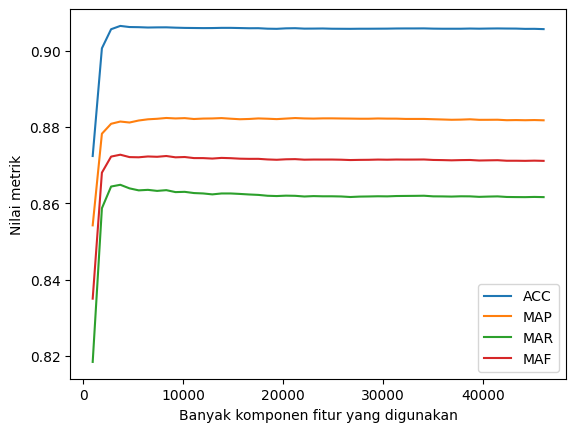

In [ ]:
limit_n = len(acc_y)
plt.plot(freq[:limit_n], acc_y[:limit_n], label='ACC')
plt.plot(freq[:limit_n], pr_y[:limit_n], label='MAP')
plt.plot(freq[:limit_n], rc_y[:limit_n], label='MAR')
plt.plot(freq[:limit_n], f1_y[:limit_n], label='MAF')
plt.xlabel('Banyak komponen fitur yang digunakan')
plt.ylabel('Nilai metrik')
plt.legend()
plt.show()